# Import necesary modules

In [72]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Load pre-trianed model

In [73]:
pretrained_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.inception_v3.decode_predictions

# Helper function for preprocessing

In [74]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (299, 299))
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Fetch the sample image

In [75]:
image_path = tf.keras.utils.get_file('hammer.jpg', 'https://4.imimg.com/data4/YL/PX/MY-3374455/mild-steel-hammer-1000x1000.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


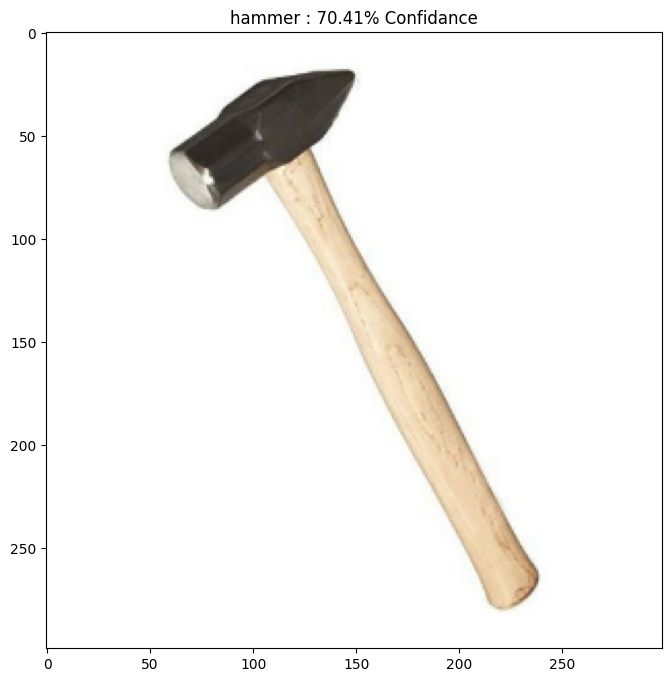

In [76]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.show()
plt.close()

# Generate adversarial pattern

In [77]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

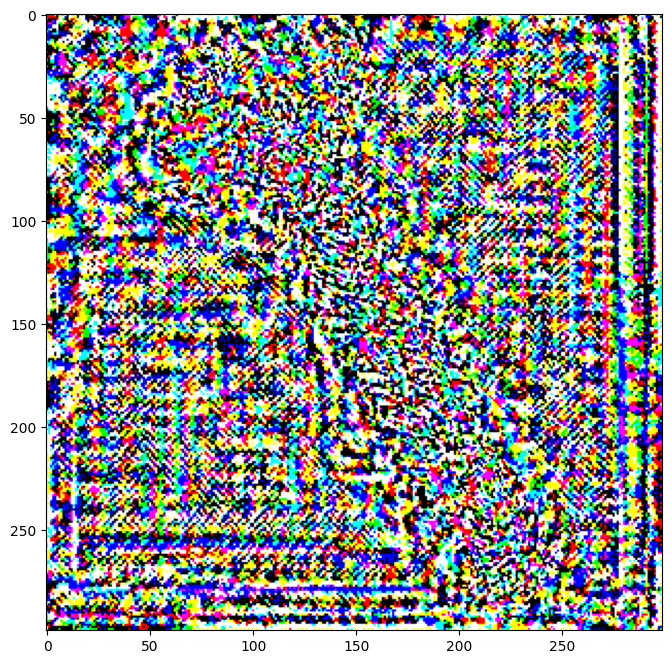

In [78]:
# Get the input label of the image.
labrador_retriever_index = 587
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

# Add perturbation

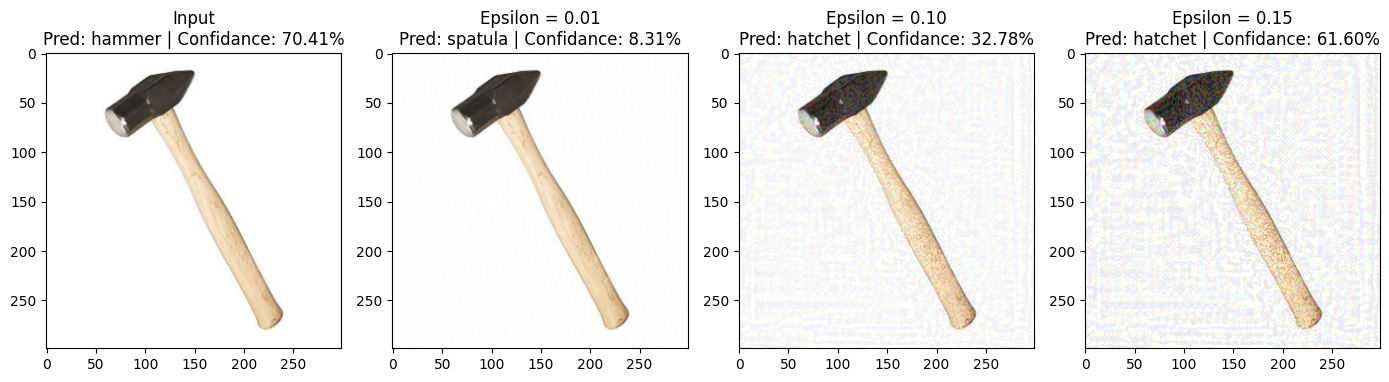

In [80]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.2f}'.format(eps) if eps else 'Input') for eps in epsilons]

plt.figure(figsize=(14, 4))

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)

    # Model prediction
    pred = pretrained_model(adv_x)
    label = get_imagenet_label(pred)

    # Plot
    plt.subplot(1, 4, i + 1)
    plt.imshow(adv_x[0] * 0.5 + 0.5)
    plt.title(f"{descriptions[i]}\nPred: {label[1]} | Confidance: {label[2]*100:.2f}%")
    # plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

# Add gaussian noise

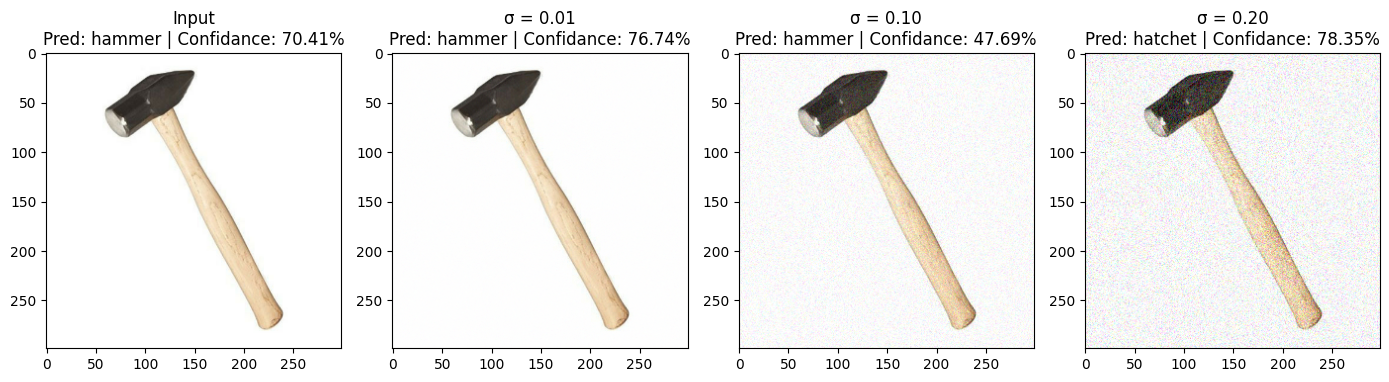

In [81]:
sigmas = [0, 0.01, 0.1, 0.2]
descriptions = [f"σ = {s:.2f}" if s else "Input" for s in sigmas]

plt.figure(figsize=(14, 4))

for i, sigma in enumerate(sigmas):
    noise = tf.random.normal(shape=image.shape, mean=0.0, stddev=sigma)
    noisy_img = image + noise
    noisy_img = tf.clip_by_value(noisy_img, -1, 1)

    # Model prediction
    pred = pretrained_model(noisy_img)
    label = get_imagenet_label(pred)

    # Plot
    plt.subplot(1, 4, i + 1)
    plt.imshow(noisy_img[0] * 0.5 + 0.5)
    plt.title(f"{descriptions[i]}\nPred: {label[1]} | Confidance: {label[2]*100:.2f}%")
    # plt.axis('off')

plt.tight_layout()
plt.show()
plt.close()